In [1]:
import requests
import pandas as pd

overpass_url = "https://lz4.overpass-api.de/api/interpreter"

# Define the query to retrieve administrative areas in Munich
query = """
[out:json][timeout:25];
area["name"="München"]->.searchArea;
(
  relation["admin_level"="9"]["boundary"="administrative"](area.searchArea);
);
out geom;
"""

# Define the parameters for the GET request
params = {
    'data': query
}

# Send a GET request to the Overpass API with the query
response = requests.get(overpass_url, params=params)
data = response.json()
data

{'version': 0.6,
 'generator': 'Overpass API 0.7.61.5 4133829e',
 'osm3s': {'timestamp_osm_base': '2023-12-07T10:13:48Z',
  'timestamp_areas_base': '2023-12-07T08:56:00Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': [{'type': 'relation',
   'id': 52747,
   'bounds': {'minlat': 48.0935434,
    'minlon': 11.6436919,
    'maxlat': 48.1591827,
    'maxlon': 11.7229099},
   'members': [{'type': 'way',
     'ref': 365092896,
     'role': 'outer',
     'geometry': [{'lat': 48.1248467, 'lon': 11.6540841},
      {'lat': 48.1246767, 'lon': 11.6540049},
      {'lat': 48.12271, 'lon': 11.6527193},
      {'lat': 48.1225841, 'lon': 11.6528273},
      {'lat': 48.121152, 'lon': 11.6518179},
      {'lat': 48.1196417, 'lon': 11.6507234},
      {'lat': 48.1198759, 'lon': 11.6500164},
      {'lat': 48.1195155, 'lon': 11.6497401},
      {'lat': 48.119193, 'lon': 11.6494333},
      {'lat': 48.1176862, 'lon': 11.6484

In [2]:
import shapely.geometry as geometry
from shapely.ops import linemerge, unary_union, polygonize

# Initialize empty lists to store polygons and names
polygons = []
names = []

# Iterate through elements in the 'data' dictionary
for element in data['elements']:
    # Check if the element is of type 'relation'
    if element.get('type') == 'relation':
        # Initialize an empty list to store LineStrings
        lss = []  # Convert ways to LineStrings
        # Iterate through members of the element
        for member in element['members']:
            if member['type'] == 'way':
                ls_coords = []  # Reset the LineString coordinate list
                nodes = member['geometry']

                # Iterate through nodes and extract lon and lat
                for point in nodes:
                    lon = point['lon']
                    lat = point['lat']
                    ls_coords.append((lon, lat))  # Append coordinate tuple

                # Create a LineString from the coordinates and add it to the list
                lss.append(geometry.LineString(ls_coords))

        # Merge the LineStrings into one
        merged = linemerge([*lss])

        # Convert the merged LineStrings into a MultiLineString
        borders = unary_union(merged)

        # Polygonize the MultiLineString to create polygons
        polygon = list(polygonize(borders))

        # Append the resulting polygon and the name from tags to respective lists
        polygons.append(polygon)
        names.append(element['tags']['name'])

In [3]:
polygons
#names

[[<POLYGON ((11.6 48.1, 11.6 48.1, 11.6 48.1, 11.6 48.1, 11.6 48.1, 11.6 48.1,...>],
 [<POLYGON ((11.5 48.1, 11.5 48.1, 11.5 48.1, 11.5 48.1, 11.5 48.1, 11.5 48.1,...>,
  <POLYGON ((11.5 48.1, 11.5 48.1, 11.5 48.1, 11.5 48.1, 11.5 48.1, 11.5 48.1,...>],
 [<POLYGON ((11.5 48.1, 11.5 48.1, 11.5 48.1, 11.5 48.1, 11.5 48.1, 11.5 48.1,...>],
 [<POLYGON ((11.5 48.1, 11.5 48.1, 11.5 48.1, 11.5 48.1, 11.5 48.1, 11.5 48.1,...>],
 [<POLYGON ((11.4 48.2, 11.4 48.2, 11.4 48.2, 11.4 48.2, 11.4 48.2, 11.4 48.2,...>],
 [<POLYGON ((11.4 48.2, 11.4 48.2, 11.4 48.2, 11.4 48.2, 11.4 48.2, 11.4 48.2,...>],
 [<POLYGON ((11.4 48.2, 11.4 48.2, 11.4 48.2, 11.4 48.2, 11.4 48.2, 11.4 48.2,...>],
 [<POLYGON ((11.5 48.2, 11.5 48.2, 11.5 48.2, 11.5 48.2, 11.5 48.2, 11.5 48.2,...>],
 [<POLYGON ((11.5 48.2, 11.5 48.2, 11.5 48.2, 11.5 48.2, 11.5 48.2, 11.5 48.2,...>],
 [<POLYGON ((11.5 48.2, 11.5 48.2, 11.5 48.2, 11.5 48.2, 11.5 48.2, 11.5 48.2,...>],
 [<POLYGON ((11.5 48.1, 11.5 48.1, 11.5 48.1, 11.5 48.1, 11.5 48.1

/Applications/anaconda3/envs/VIZ/lib/python3.10/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Applications/anaconda3/envs/VIZ/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


NameError: name 'plt' is not defined

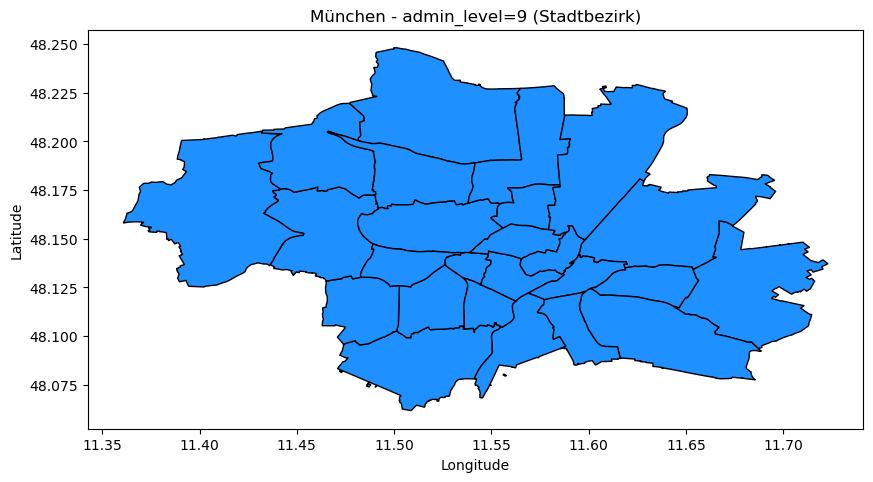

In [4]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

# Create a list of MultiPolygons
multipolygons = [MultiPolygon(polygon) for polygon in polygons]

# Create a GeoDataFrame
geo_data = {'Name': names, 'geometry': multipolygons}
df = gpd.GeoDataFrame(geo_data)

# Save the GeoDataFrame as a JSON file
df.to_file('neighbourhoods_munich.json', driver='GeoJSON')

# Create a plot
ax = df.plot(
    figsize=(10, 10),     # Set the figure size (width, height)
    color='dodgerblue',   # Set the color of polygons
    edgecolor='black',    # Set the color of polygon edges
    linewidth=1.0,        # Set the width of polygon edges
    alpha=1.0,            # Set the transparency level (0.0 to 1.0)
)

# Add a title
ax.set_title("München - admin_level=9 (Stadtbezirk)")

# Add labels, legend, etc. as needed
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [3]:
data['features'][1]['properties']['name']

KeyError: 'features'

In [ ]:
pop_data = [['Allach-Untermenzing',92000],
            ['Altstadt-Lehel',476744],
            ['Au-Haidhausen',294743],
            ['Aubing-Lochhausen-Langwied',207332],
            ['Berg am Laim',164746],
            ['Bogenhausen',154422],
            ['Feldmoching-Hasenbergl',55485],
            ['Hadern',169067],
            ['Laim',464165],
            ['Ludwigsvorstadt-Isarvorstadt',328362],
            ['Maxvorstadt',325976],
            ['Milbertshofen-Am Hart',428332],
            ['Moosach',325173],
            ['Neuhausen-Nymphenburg',79904],
            ['Pasing-Obermenzing',53774],
            ['Pasing-Obermenzing',170336],
            ['Ramersdorf-Perlach',24093],
            ['Schwabing-Freimann',199200],
            ['Schwabing-West',171210],
            ['Schwanthalerhöhe',413025],
            ['Sendling',129162],
            ['Sendling-Westpark',422903],
            ['Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln',325858],
            ['Trudering-Riem',117109],
            ['Untergiesing-Harlaching',352348]]
pop_df = pd.DataFrame(pop_data, columns=['name', 'population'])
#pop_df
fig = px.choropleth_mapbox(pop_df, geojson=data,
                        color="population",
                        locations="name", featureidkey="properties.name",
                        center={"lat": center_lat, "lon": center_lng},
                        mapbox_style="carto-positron", zoom=10)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})